In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset

In [2]:
torch.manual_seed(30)

In [3]:
def get_origin_mgrid(sidelen1,sidelen2, dim=2):
    if sidelen1 >=sidelen2:
      tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen1)])
      mgrid = torch.stack(torch.meshgrid(*tensors, indexing='ij'), dim=-1)
    
      minor=int((sidelen1-sidelen2)/2)
      mgrid=mgrid[:,minor:sidelen2+minor]
    if sidelen1 <sidelen2:
      tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen2)])
      mgrid = torch.stack(torch.meshgrid(*tensors, indexing='ij'), dim=-1)
      
      minor=int((sidelen2-sidelen1)/2)
      mgrid=mgrid[minor:sidelen1+minor,:]
    mgrid = mgrid.reshape(-1, dim)
   
    return mgrid

In [4]:
class SineLayer(nn.Module):
 
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output  

In [5]:
from scipy.io import loadmat
data=loadmat("data.mat")
d=data['dn']
dn=data['dbp']
noisy_tensor = torch.from_numpy(np.expand_dims(dn,axis=0)).float()

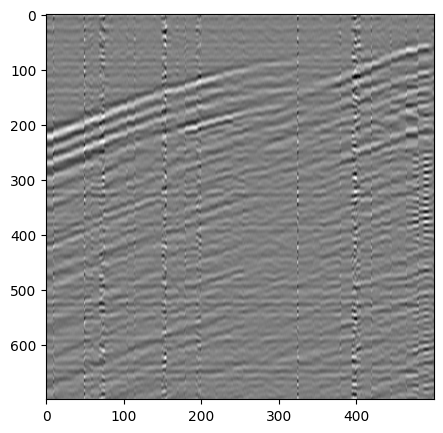

In [6]:
plt.figure(figsize=(5,5))
plt.imshow(dn,vmin=-1,vmax=1,aspect='auto',cmap='gray')

In [7]:
def regular_patching_1D(data,patchsize=32, step=16, verbose=True):
    # find starting indices
    x_start_indices = np.arange(0, data.shape[0] - patchsize, step=step)

    if verbose:
        print('Extracting %i patches' % len(x_start_indices))

    patches = np.zeros([len(x_start_indices), patchsize,data.shape[1]])

    for i, pi in enumerate(x_start_indices):
        patches[i] = data[pi:pi+patchsize,:]

    return patches

In [8]:
def make_data_loader(coords_patch, 
                     pixels_patch,
                     batch_size
                    ):
    train_X = np.expand_dims(coords_patch,axis=1)
    train_y = np.expand_dims(pixels_patch,axis=1)     
    train_dataset = TensorDataset(torch.from_numpy(train_X).float(), 
                                  torch.from_numpy(train_y).float(),
                                  )
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
    return train_loader

In [9]:
coords = get_origin_mgrid(noisy_tensor.shape[1],noisy_tensor.shape[2],dim=2)
desired_shape = (dn.shape[0]*dn.shape[1],1)
pixels= noisy_tensor.reshape(desired_shape)
coords_patch=regular_patching_1D(coords,patchsize=128, step=64)
pixels_patch=regular_patching_1D(pixels,patchsize=128, step=64)

Extracting 5467 patches
Extracting 5467 patches


In [10]:
model = Siren(in_features=2, out_features=2, hidden_features=256, 
                  hidden_layers=6, outermost_linear=True, first_omega_0=15, hidden_omega_0=15)
model.cuda()


Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (5): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (6): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (7): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [11]:
def horizontal_finite_difference(x):
    """Computes the horizontal finite difference ∇_x x"""
    return x[:,:, 1:, :] - x[:,:, :-1, :]

In [12]:
torch.cuda.empty_cache() 
max_epoch = 300
optimizer = torch.optim.Adam(lr=2e-5, params=model.parameters())
losses = []
dataloader= make_data_loader(coords_patch,pixels_patch,batch_size =128)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=10, verbose=False)
for epoch in tqdm(range(max_epoch)):
    running_loss = 0.0
    for dl in (dataloader):
        model_input, ground_truth = dl[0].cuda(), dl[1].cuda()
    # Forward pass
        model_output = model(model_input)
    
    # Split the model output into two components
        output_coherent = model_output[:,:, :, 0:1]  # Coherent noise
        output_denoised = model_output[:,:, :, 1:2]  # Denoised result
     
    # Compute losses
        tv_loss = torch.mean(torch.abs(horizontal_finite_difference(output_coherent)))  # Coherent noise modeling
        l1_loss1=nn.L1Loss()(output_coherent, ground_truth)
        l1_loss2=nn.L1Loss()(output_denoised, ground_truth)
    
    # weighted total loss
        loss = l1_loss2+5*(l1_loss1 + 20 * tv_loss)
    
    # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(dataloader)   
    #scheduler.step(epoch_loss)    
    losses.append(epoch_loss)



  0%|          | 0/300 [00:00<?, ?it/s]

In [13]:
coords_tensor = coords.clone().detach()
test_input = coords_tensor.unsqueeze(0)
test_input=test_input.to(torch.float)
test_input=test_input.cuda()
model_output=model(test_input)
dr=model_output.cpu().view(dn.shape[0],dn.shape[1],2).detach().numpy().squeeze()  

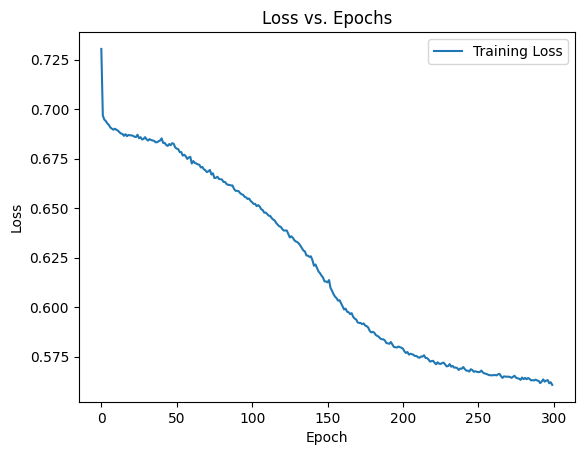

In [14]:
plt.plot(range(0, max_epoch ), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.show()

Text(0.5, 1.0, '(f)')

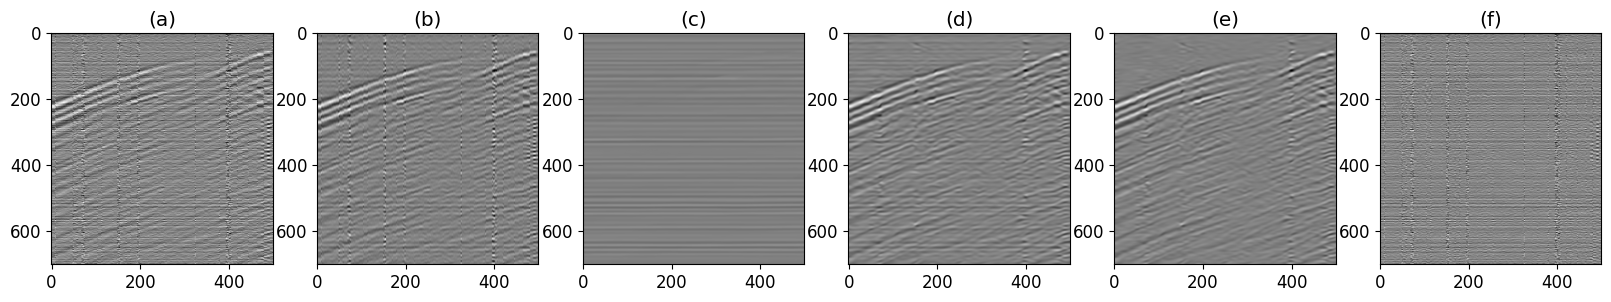

In [15]:
denoised=np.squeeze(dr[:,:,1]-dr[:,:,0])
plt.figure(figsize=(20,3))
plt.rcParams.update({'font.size':12})
plt.subplot(161)
plt.imshow(d,vmin=-1,vmax=1,aspect='auto',cmap='gray')
plt.title('(a)')
plt.subplot(162)
plt.imshow(dn,vmin=-1,vmax=1,aspect='auto',cmap='gray')
plt.title('(b)')
plt.subplot(163)
plt.imshow(np.squeeze(dr[:,:,0]),vmin=-1,vmax=1,aspect='auto',cmap='gray')
plt.title('(c)')
plt.subplot(164)
plt.imshow(np.squeeze(dr[:,:,1]),vmin=-1,vmax=1,aspect='auto',cmap='gray')
plt.title('(d)')
plt.subplot(165)
plt.imshow(denoised,vmin=-1,vmax=1,aspect='auto',cmap='gray')
plt.title('(e)')
plt.subplot(166)
plt.imshow(d-denoised,vmin=-1,vmax=1,aspect='auto',cmap='gray')
plt.title('(f)')

Text(0.5, 1.0, '(c)')

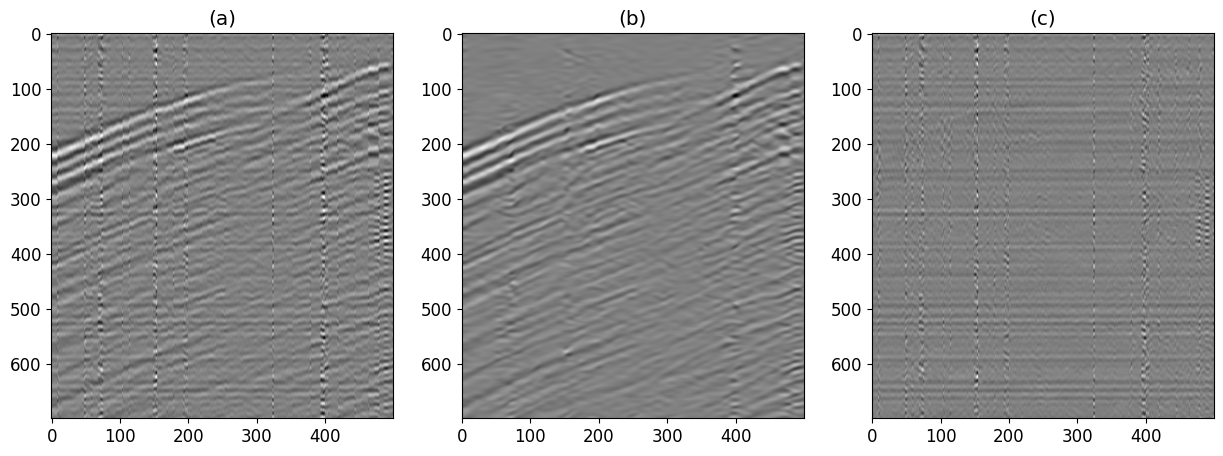

In [16]:
plt.figure(figsize=(15,5))
plt.rcParams.update({'font.size':12})
plt.subplot(131)
plt.imshow(dn,vmin=-1,vmax=1,aspect='auto',cmap='gray')
plt.title('(a)')
plt.subplot(132)
plt.imshow(denoised,vmin=-1,vmax=1,aspect='auto',cmap='gray')
plt.title('(b)')
plt.subplot(133)
plt.imshow(dn-denoised,vmin=-1,vmax=1,aspect='auto',cmap='gray')
plt.title('(c)')